# 과제1: tensorflow를 이용한 NN 밑바닥부터 구현
input feature가 100개이고,  
hidden layer가 2개이고 neuron이 각각 50,10개이고,  
output이 5개인 NN를 구현해 보자  
* hidden layer는 relu를 activation function으로, output layer는 softmax를 activation function으로 사용

In [7]:
!pip3 install tensorflow

In [36]:
import tensorflow as tf
import numpy as np

In [37]:
n_x = 100
n_h1 = 50
n_h2 = 10
n_y = 5

In [38]:
# Simulate train set
m = 500

x_train=np.random.randn(m,n_x).astype(np.float32)
y_train=np.zeros((m,n_y)).astype(np.float32)
y_train[np.arange(m),np.random.randint(n_y,size=m)]=1

print(x_train)
print(y_train)

[[ 1.2124896  -0.21180828 -0.08910526 ...  0.99292123  0.8294151
  -0.01366135]
 [-1.348126    0.2476664   0.6406654  ... -1.296355   -1.9140676
  -0.15290621]
 [ 1.3948125   0.60749257 -0.32510254 ... -0.76768476  0.4577213
   0.7250878 ]
 ...
 [ 1.8825585   1.2281501   1.147263   ... -1.7443273   0.04199841
   0.04566711]
 [-0.09637723  0.30329362 -0.31719157 ... -0.13620797  1.8866997
  -1.1594032 ]
 [ 0.2885809  -1.7707328  -0.7536415  ... -0.32551527 -0.7265424
   0.6501261 ]]
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


* Initialization of weights

In [39]:
w1=tf.Variable(1e-3*np.random.randn(n_x,n_h1).astype(np.float32),name="w1")
## 코드를 작성해 보세요 ##
w2=tf.Variable(1e-3*np.random.randn(n_h1,n_h2).astype(np.float32),name="w2")
w3=tf.Variable(1e-3*np.random.randn(n_h2,n_y).astype(np.float32),name="w3")

* forward propagation을 통해 prediction 값을 구하고, loss를 구하는 function을 만들어 봅시다

In [40]:
def forward(x):
    z1=tf.matmul(x,w1)
    a1=tf.nn.relu(z1)
    z2=tf.matmul(a1,w2)
    a2=tf.nn.relu(z2)
    z3=tf.matmul(a2,w3)
    predictions = tf.nn.softmax(z3)
    
    return predictions

def loss_fn(predictions, y):
    loss= -tf.reduce_sum(y*tf.math.log(predictions))
    return loss    

* backpropagation & update parameters

In [41]:
learning_rate=1e-2
optimizer=tf.keras.optimizers.Adam(learning_rate)

def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = forward(x)
        loss = loss_fn(predictions, y)
    gradient = tape.gradient(loss, [w1, w2])
    
    # optimizer와 위에서 구한 경사도를 이용해 가중치들을 업데이트 합니다.
    optimizer.apply_gradients(zip(gradient, [w1, w2]))
    return loss, w1, w2


* 간단하게 train loop를 작성해 loss가 줄어나가는지 확인해 봅시다.

In [42]:
loss_list = []

for step in range(10): 
    loss, w1, w2 = train_step(x_train, y_train)
    loss_list.append(loss.numpy())
    
print(loss_list)

[804.7188, 804.71796, 804.70636, 804.68195, 804.6398, 804.5768, 804.48987, 804.3779, 804.2382, 804.0683]


# 과제2: MNIST 데이터를 나만의 NN model로 95 % 이상의 성능으로 training 시켜보자!


## Loading MNIST training data

In [43]:
from tensorflow import keras

# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scaling(image data는 min-max scaling 주로 사용)
x_train = x_train/255.0
x_test = x_test/255.0

## Training Data
28 * 28 pixel 값을 가진 총 60000개의 이미지 데이터

In [44]:
x_train.shape 

(60000, 28, 28)

Neural network 모델에 맞게 이미지 데이터를 벡터 형태로 데이터를 reshape 합니다.  
(Model을 만들 때 *keras.layers.Flatten(input_shape=(28, 28)) 이용해도 됨)

In [45]:
x_train, x_test = x_train.reshape((-1, 28*28)), x_test.reshape((-1, 28*28))
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

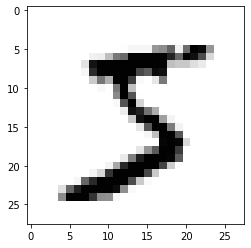

In [46]:
tmp = np.reshape(x_train[0], (28, 28))
plt.imshow(tmp).set_cmap('Greys')

## Training Labels
이미지 데이터가 나타내는 숫자값을 label로 가지고 있고, 0부터 9까지의 값을 나타냄  
마찬가지로, 60000개의 label이 존재

In [47]:
y_train.shape

(60000,)

In [48]:
# show MNIST label for above data
y_train[0]

5

## 나만의 모델을 tensorflow keras API 를 이용해 만들어 봅시다~

* parameters for model

In [49]:
activation_list = ["sigmoid", "relu", "softmax", "tanh"]

loss_list = ["sparse_categorical_crossentropy",
             "categorical_crossentropy", 
             "binary_crossentropy"]

optimizer_list = ["sgd", "adam", "rmsprop", "adagrad"]

initializer_list = [tf.keras.initializers.RandomNormal(), 
                    tf.keras.initializers.RandomUniform(), 
                    tf.keras.initializers.he_normal(), 
                    tf.keras.initializers.he_uniform(), 
                    tf.keras.initializers.GlorotUniform(),
                    tf.keras.initializers.GlorotNormal()]

# dropout
dropout_rate = 0.3
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation = "sigmoid"),
    tf.keras.layers.Dense(2, activation = "sigmoid"),
    tf.keras.layers.Dropout(dropout_rate)
])


# regularizer
regularizer = tf.keras.regularizers.l1(1e-3)
regularizer = tf.keras.regularizers.l2(1e-3)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          activity_regularizer=regularizer)
])

# weight initialization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          kernel_initializer=initializer_list[0])
])

#### My Own Model 

In [78]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(300, input_dim=784, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal()),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(100, activation='relu' ,kernel_initializer=tf.keras.initializers.RandomNormal()),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(50, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal()),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(10, activation='softmax'),
])

In [79]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_20 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_22 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 10)              

In [85]:
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = 'adam',
              metrics = ["accuracy"]
              )

In [86]:
model.fit(x_train, y_train, epochs=30, verbose=1, validation_split=0.2, batch_size = 32)

Epoch 1/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1720 - accuracy: 0.9640 - val_loss: 0.1173 - val_accuracy: 0.9735
Epoch 2/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1174 - accuracy: 0.9672 - val_loss: 0.1149 - val_accuracy: 0.9737
Epoch 3/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1117 - accuracy: 0.9691 - val_loss: 0.1034 - val_accuracy: 0.9747
Epoch 4/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1014 - accuracy: 0.9716 - val_loss: 0.1038 - val_accuracy: 0.9758
Epoch 5/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0965 - accuracy: 0.9740 - val_loss: 0.1064 - val_accuracy: 0.9773
Epoch 6/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0879 - accuracy: 0.9749 - val_loss: 0.1054 - val_accuracy: 0.9775
Epoch 7/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0815 - accuracy: 0.9777 - val_loss: 0.1054 - val_accuracy:

95%이상의 성능을 가진 모델을 만들면 완성!

In [87]:
test_loss, test_acc = model.evaluate(x_test,y_test, verbose=2)

print('Accuracy:', test_acc)

313/313 - 0s - loss: 0.1148 - accuracy: 0.9808
Accuracy: 0.9807999730110168


![](https://www.tensorflow.org/versions/master/images/mnist_tensorboard.png)